<a href="https://colab.research.google.com/github/toful/Shazam/blob/master/src/Shazam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.io import wavfile
import numpy as np
from skimage.feature import peak_local_max
import hashlib
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [0]:
audio_file = 'file_example_WAV_1MG.wav' 
sample_rate, samples = wavfile.read( audio_file )

if len( samples[0] ) > 1:
  samples = samples[:, 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


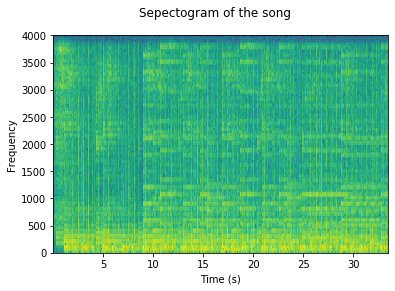

In [0]:
#default values
NFFT = 256
noverlap = int(NFFT * 0.5)

plt.suptitle("Sepectogram of the song")
plt.xlabel( "Time (s)" )
plt.ylabel( "Frequency")
spectrum, freqs, t, spectrum_plot = plt.specgram(
    samples,
    NFFT=NFFT, 
    Fs=sample_rate, 
    detrend = mlab.detrend_none,
    window = mlab.window_hanning,
    noverlap = noverlap )

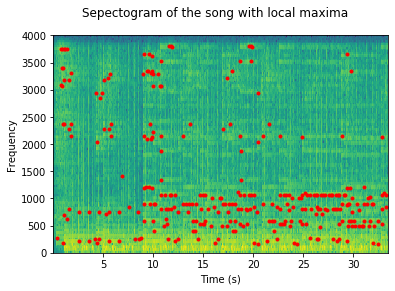

In [0]:
#Getting the coords of the local max peaks
min_distance = 5
threshold_abs = 0.0   #Minimum intensity of peaks. By default, the minimum intensity of the image.
threshold_rel = 0.0   #Minimum intensity of peaks, calculated as: max(image) * threshold_rel.
num_peaks = 300

coord = peak_local_max( spectrum, 
                        min_distance=min_distance,
                        threshold_abs = threshold_abs,
                        threshold_rel = threshold_rel,
                        num_peaks = num_peaks )
coord_aux = np.column_stack( ( np.take( freqs, coord[:, 0]), np.take( t, coord[:, 1]) ) )

#Printing the spectogram with the peaks
plt.suptitle("Sepectogram of the song with local maxima")
plt.xlabel( "Time (s)" )
plt.ylabel( "Frequency")
plt.plot(coord_aux[:, 1], coord_aux[:, 0], 'r.')
plt.specgram( samples, NFFT=NFFT, Fs=sample_rate, detrend = mlab.detrend_none, window = mlab.window_hanning, noverlap = noverlap )

plt.show()

In [0]:
#Sort the list of [freqs , time] using the time
coord_aux = coord_aux[ coord_aux[:,1].argsort() ]

#Number of links for each node
num_links = 5

song_hashes = []
for i in range( 0, len(coord_aux) - num_links ):
  for j in range( i+1, i+num_links ):
    #freq1 + freq2 + time difference (avoid the decimal values?)
    aux = str( coord_aux[i, 0] ) + str( coord_aux[j, 0] ) + str( coord_aux[j, 1] - coord_aux[i, 1] )
    song_hashes += [ [hashlib.md5( aux.encode('utf-8') ).hexdigest(), coord_aux[i,1]] ]


[[1.]]
Mean Squared Error: 1.8866252516446392e-34


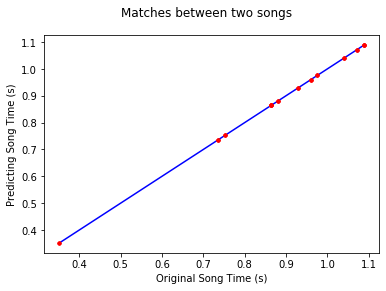

In [0]:
#Comparing two songs
song2_hashes = song_hashes[1:50]

coincidences = []
for i in range( 0, len(song_hashes) ):
  for j in range( 0, len(song2_hashes) ):
    if song_hashes[i][0] == song2_hashes[j][0]:
      coincidences += [ [song_hashes[i][1], song2_hashes[j][1]] ]

coincidences = np.array( coincidences )
#look for the straight line in the scatter plot
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit( coincidences[:, 0].reshape(-1, 1) ,  coincidences[:, 1].reshape(-1, 1) )  # perform linear regression
Y_pred = linear_regressor.predict( coincidences[:, 0].reshape(-1, 1) )  # make predictions
plt.plot( coincidences[:, 0], Y_pred, color='blue' )
print( linear_regressor.coef_ )
print('Mean Squared Error:', metrics.mean_squared_error(coincidences[:, 0], Y_pred)) 

plt.suptitle("Matches between two songs")
plt.xlabel( "Original Song Time (s)" )
plt.ylabel( "Predicting Song Time (s)")
plt.plot( coincidences[:, 0], coincidences[:, 1], 'r.')

plt.show()